## SINDYc-MPC for Lotka model

### This notebook study the Lotka-Volterra system in the paper "Sparse identification of nonlinear dynamics for model predictive control in the low-data limit".

### The dynamics is governing by the equations:
$$ .
\begin{aligned}
\dot{x}_1 &=  a x_1 − b x_1 x_2 \\
\dot{x}_2 &= −c x_2 + d x_1 x_2 + u, 

\end{aligned}
$$

In [2]:
%reload_ext autoreload 
%autoreload 2

In [3]:
import numpy as np
from lotkacontrol import lotkacontrol,lotacontrol_jac,lotkacontrol_class, lotkacontrol_discrete
from scipy import integrate
from SINDYc_utils import poolData,sparseGalerkinControl,sparsifyDynamics, lotkaObjectiveFCN, rk4u, lotkaObjectConstraint_cvxpy
import cvxpy as cp
import scipy
from tqdm import tqdm
# Parameters: SINDy
polyorder = 3
usesine = 0

# True Parameters of Lotka-Volterra model
a = .5
b = .025
d = .005
g = .5
n = 2
x0=np.array([60,50])
dt = .01

# Choose forcing function to excite system for model identification
# forcing = lambda x,t: (0.33*(np.sin(1*t)+np.sin(.1*t)))**2
forcing = lambda x,t: (2*(np.sin(1*t)+np.sin(.1*t)))**2

# Integrate excited system
tspan= np.arange(0,100,dt) # t is setting in the range of 0-100 seconds
u = forcing(0,tspan)
N = len(tspan)

# #-------old API------------
# r = integrate.ode(lotkacontrol, lotacontrol_jac).set_integrator('dopri5', rtol=1e-10, atol= 1e-10)
# r.set_initial_value(x0, tspan[0]).set_f_params(forcing,a,b,d,g).set_jac_params(forcing,a,b,d,g)
# print('ode sol',r.integrate(1)) # integrate 1 seconds
# #-------new API------------
# func = lotkacontrol_class.lotka_func(forcing,a,b,d,g)
# r = integrate.RK45(func,0,x0,rtol=1e-10,atol=1e-10,t_bound=1,max_step=100)
# for i in range(100):
#     r.step()
#     # break loop after modeling is finished
#     if r.status == 'finished':
#         break
# print('RK45 sol',r.y)

#------new API-------
sol_train = integrate.solve_ivp(lotkacontrol, [0,100], x0, method='RK45', t_eval=tspan, rtol=1e-10, atol=1e-10, args= (forcing,a,b,d,g))
x = (sol_train.y).T
print('solve_ivp sol',sol_train.y[...,-1])
print(sol_train.y.shape)

# SINDYc Model Identification
# Compute Derivative
dx = np.zeros_like(x)
for t_step in range(x.shape[0]):
    dx[t_step,:] = lotkacontrol(tspan[t_step],x[t_step,:],forcing,a,b,d,g)

x = np.concatenate((x, u.reshape(-1,1)),axis=1)
dx = np.concatenate((dx, np.zeros((x.shape[0],1))), axis=1 )

#------add noise------
eps = 0.1
dx = dx + eps*np.random.randn(*dx.shape)
n = x.shape[1] # variable dimension

#------------SINDYc learning--------------
#Sparse regression
Theta = poolData(x,polyorder,usesine)

Lambda = 0.001       # lambda is our sparsification knob. 
Xi = sparsifyDynamics(Theta,dx,Lambda,n)
# poolDataLIST({'x','y','u'},Xi,n,polyorder,usesine)

#---validation----
#----change forcing function-----
forcing = lambda x,t: (0.33*(np.sin(1*t)+np.sin(.1*t)))**2
tspan_validation= np.arange(100,200,dt)
x0 = x[-1,:2]
u_validation = forcing(0,tspan_validation)
sol = integrate.solve_ivp(lotkacontrol, [100,200], x0, method='RK45', t_eval=tspan_validation, rtol=1e-10, atol=1e-10, args= (forcing,a,b,d,g)) # true model 
sol_approx = integrate.solve_ivp(sparseGalerkinControl,[100,200], x0, method='RK45', t_eval=tspan_validation, rtol=1e-10, atol=1e-10, args=(forcing,Xi[:,:-1], polyorder, usesine)) # approximation model




solve_ivp sol [70.177355   30.59727522]
(2, 10000)


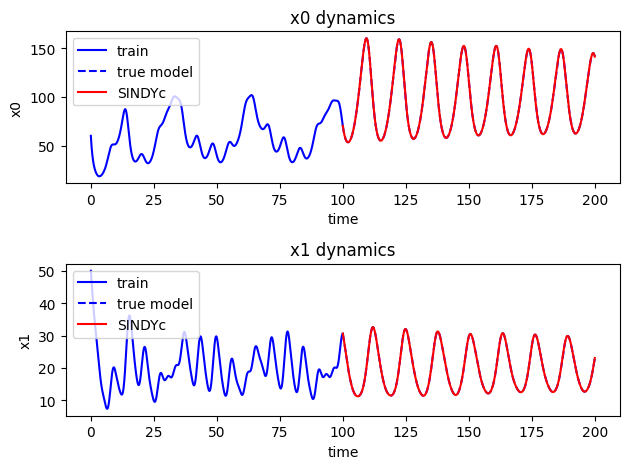

In [4]:
import matplotlib.pyplot as plt 
fig = plt.figure()
# fig.tight_layout(pad=20.0)
index = 211
for i in range(2):
    
    ax = fig.add_subplot(index)
    plt.title(f'x{i} dynamics')
    plt.xlabel('time')
    plt.ylabel(f'x{i}')
    ax.plot(sol_train.t,sol_train.y[i,:],'b', label='train')
    ax.plot(sol.t, sol.y[i,:],'b--',label='true model')
    ax.plot(sol_approx.t, sol_approx.y[i,:],'r', label='SINDYc')
    ax.legend()
    index += 1

fig.tight_layout()


In [34]:
import time
import cProfile
from line_profiler import LineProfiler
def SINDY_MPC():
    # Apply Model predictive controlto system using SINDYc model
    pest = (polyorder, usesine, Xi)
    p = (a, b, d, g)

    # Choose prediction horizon over which the optimization is performed
    # Nvec = [1,3,5,7,10,15,20,25,30,35,40,45,50] 
    Nvec = [12]
    Ts          = 0.1              # Sampling time
    Duration    = 100             # Run control for 100 time units
    Nvar        = 2                # number of variable
    Q           = np.array([1,0])
    R           = 0.5               # Control variation du weights
    Ru = 0.5                        # Control weights
    weights      = (np.diag(Q),R,Ru)
    B = np.array([[0,0], [0,1]])    # Control vector (which state is controlled)
    C = np.eye(Nvar)                # Measurement matrix
    D = 0                           # Feedforward (none)
    x0=np.array([60,50])            # init state
    for i in range(len(Nvec)):
        
        N           = Nvec[i]           # Control / prediction horizon (number of iterations)
        x0n=x0                          # Initial condition
        uopt0 = 0                       # Set initial control input to zero
        
        # Constraints on control optimization
        LB = []                         # Lower bound of control input
        UB = []                         # Upper bound of control input
    
        # Reference state, which shall be achieved
        xref1 = np.array([g/d,a/b])     # critical point
        # xref1 = [50 0]       # Reference values
        # xref2 = [50 0] 
        # xref_vec = [xref1(1)*ones(size(0:Ts:10)),xref2(1)*ones(size(10+Ts:Ts:Duration)) 
        #             xref1(2)*ones(size(0:Ts:10)),xref2(2)*ones(size(10+Ts:Ts:Duration))] 
        
        
        # Start simulation
        print('Simulation started.  It might take a while...\n')
        x        = x0n
        Ton      = 0*Ts       # Time when control starts
        iter     = int(Duration/Ts)
        uopt     = uopt0*np.ones(N) 
        xHistory = np.zeros((Nvar,iter))       # Stores state history
        xHistory[:,0] = x
        uHistory = [uopt[0]]  # Stores control history
        tHistory = np.arange(0,Duration,Ts)        # Stores time history
        rHistory = np.zeros((Nvar,iter))     # Stores reference (could be trajectory and vary with time)
        rHistory[:,0] = xref1

        for ct in tqdm(range(iter)):   # For each iteration: take measurements & optimize control input & apply control input
            if ct*Ts>Ton and np.linalg.norm(x-xref1)>0.000001:            # Turn control on
                if ct*Ts==Ton+Ts:
                    print('Start control.')
                
                # Set references
                xref = xref1 
                
                # NMPC with full-state feedback
                COSTFUN = lambda uu: lotkaObjectiveFCN(uu,x,Ts,N,xref,uopt[0],pest,np.diag(Q),R,Ru)
                # t0 = time.time()
                #----cvxpy-----
                # uu = cp.Variable(N)
                # xx = cp.Variable((N,Nvar))
                # delta_u = cp.Variable(N)
                # uopt,xopt,dopt = lotkaObjectConstraint_cvxpy(uu,xx,delta_u,uopt[0],x,xref,weights,Ts,pest)
                
                res = scipy.optimize.minimize(COSTFUN,uopt,method='L-BFGS-B')
                uopt = res.x
                # t = time.time()
                # print(t-t0)

                # uopt = fmincon(COSTFUN,uopt,[],[],[],[],LB,UB,CONSFUN,options) 
                #  uopt = fmincon(COSTFUN,uopt,[],[],[],[],LB,UB,[],options) 
                #  #use this without constraint functions CONSFUN
                
            else:                    # If control is off
                uopt = uopt0*np.ones(N) 
                # print('contorl off')

            
            # Integrate system: Apply control & Step one timestep forward
            # sol = integrate.solve_ivp(lotkacontrol_discrete, [0,Ts], x, method='RK45', t_eval=None, rtol=1e-10, atol=1e-10, args= (uopt[0],a,b,d,g)) # true model
            # x = sol.y[...,-1] #update state
            x = rk4u(lotkacontrol_discrete,x,uopt[0],Ts,1,[],p)
            xHistory[:,ct] = x 
            uHistory.append(uopt[0]) 
            rHistory[:,ct] = xref1
    
            
        print('Simulation finished!\n')
    return xHistory, uHistory, tHistory, rHistory
# cProfile.run('xHitory,uHistory,tHistory, rHistory = SINDY_MPC()')
xHistory,uHistory,tHistory, rHistory = SINDY_MPC()
# lp = LineProfiler()
# lp_wrapper = lp(SINDY_MPC)
# lp_wrapper()
# lp.print_stats()


Simulation started.  It might take a while...



  0%|          | 0/1000 [00:00<?, ?it/s]

Start control.


100%|██████████| 1000/1000 [01:12<00:00, 13.88it/s]

Simulation finished!



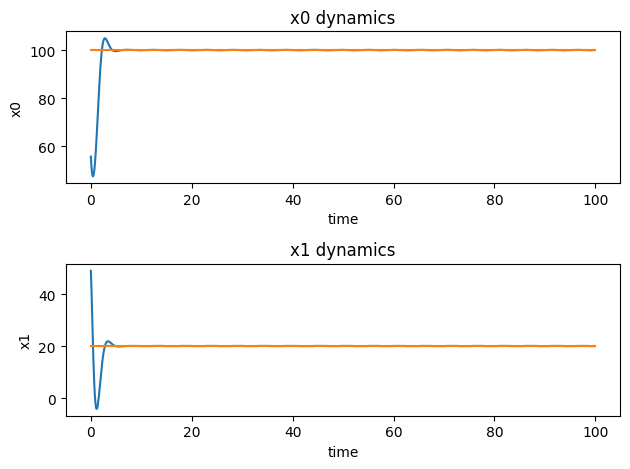

In [33]:
 ## Show results
fig,axs = plt.subplots(2,1)
for i in range(2):
    axs[i].plot(tHistory,xHistory[i,:])
    axs[i].plot(tHistory,rHistory[i,:])
    axs[i].set_title(f'x{i} dynamics')
    axs[i].set_xlabel('time')
    axs[i].set_ylabel(f'x{i}')
plt.tight_layout()

In [37]:
a = np.array([[1,2,3],[4,5,6]])
b = np.array([[2,1,4],[5,6,3]])
print('a',a)
print('b',b)
c =(np.einsum('ij,ik->ijk',a,a))
print(c)
ind = np.triu_indices(3)
print(ind)
print(c[0][ind])
print(c[:,ind[0],ind[1]])
print(c.reshape(2,9))
# d = (np.einsum('ij,ik->ijk',a,c)).reshape(2,27)
# print(d)

a [[1 2 3]
 [4 5 6]]
b [[2 1 4]
 [5 6 3]]
[[[ 1  2  3]
  [ 2  4  6]
  [ 3  6  9]]

 [[16 20 24]
  [20 25 30]
  [24 30 36]]]
(array([0, 0, 0, 1, 1, 2]), array([0, 1, 2, 1, 2, 2]))
[1 2 3 4 6 9]
[[ 1  2  3  4  6  9]
 [16 20 24 25 30 36]]
[[ 1  2  3  2  4  6  3  6  9]
 [16 20 24 20 25 30 24 30 36]]
